<a href="https://colab.research.google.com/github/oysteric/ai-cup-notebook/blob/main/ai_cup_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI Cup Prediction
Identify LalaLoop Cup

# Install AWS Dependencies

In [ ]:
!pip install boto3

!pip install aws configure

!pip install awscli

!aws configure

## Start Model

In [ ]:

import boto3

def start_model(project_arn, model_arn, version_name, min_inference_units):

    client=boto3.client('rekognition','ap-northeast-2')

    try:
        # Start the model
        print('Starting model: ' + model_arn)
        response=client.start_project_version(ProjectVersionArn=model_arn, MinInferenceUnits=min_inference_units)
        # Wait for the model to be in the running state
        project_version_running_waiter = client.get_waiter('project_version_running')
        project_version_running_waiter.wait(ProjectArn=project_arn, VersionNames=[version_name])

        #Get the running status
        describe_response=client.describe_project_versions(ProjectArn=project_arn,
            VersionNames=[version_name])
        for model in describe_response['ProjectVersionDescriptions']:
            print("Status: " + model['Status'])
            print("Message: " + model['StatusMessage'])
    except Exception as e:
        print(e)

    print('Done...')

def main():
    project_arn='arn:aws:rekognition:ap-northeast-2:834156266533:project/LalaLoopCup/1704731324007'
    model_arn='arn:aws:rekognition:ap-northeast-2:834156266533:project/LalaLoopCup/version/LalaLoopCup.2024-01-10T17.03.56/1704873836746'
    min_inference_units=1
    version_name='LalaLoopCup.2024-01-10T17.03.56'
    start_model(project_arn, model_arn, version_name, min_inference_units)

if __name__ == "__main__":
    main()

## Analyze Image

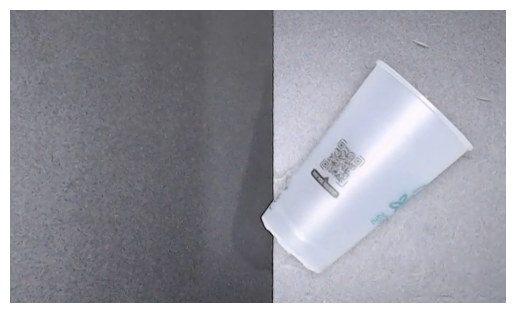

Analyzing image... field-test/test1.png
Labels detected: [{'Name': 'LalaLoopCup', 'Confidence': 85.7770004272461}]


In [48]:
import boto3
import io
from PIL import Image, ImageDraw, ExifTags, ImageColor, ImageFont
from matplotlib import pyplot as plt

def display_image_objects(bucket,photo,response):

    # Load image from S3 bucket
    s3_connection = boto3.resource('s3')
    s3_object = s3_connection.Object(bucket,photo)
    s3_response = s3_object.get()

    stream = io.BytesIO(s3_response['Body'].read())
    image=Image.open(stream)


    # Ready image to draw bounding boxes on it.
    imgWidth, imgHeight = image.size
    draw = ImageDraw.Draw(image)

    # calculate and display bounding boxes for each detected custom label
    print('Detected custom labels for ' + photo)
    for customLabel in response['CustomLabels']:
        print('Label ' + str(customLabel['Name']))
        print('Confidence ' + str(customLabel['Confidence']))
        if 'Geometry' in customLabel:
            box = customLabel['Geometry']['BoundingBox']
            left = imgWidth * box['Left']
            top = imgHeight * box['Top']
            width = imgWidth * box['Width']
            height = imgHeight * box['Height']

            fnt = ImageFont.truetype('/Library/Fonts/Arial.ttf', 50)
            draw.text((left,top), customLabel['Name'], fill='#00d400', font=fnt)

            print('Left: ' + '{0:.0f}'.format(left))
            print('Top: ' + '{0:.0f}'.format(top))
            print('Label Width: ' + "{0:.0f}".format(width))
            print('Label Height: ' + "{0:.0f}".format(height))

            points = (
                (left,top),
                (left + width, top),
                (left + width, top + height),
                (left , top + height),
                (left, top))
            draw.line(points, fill='#00d400', width=5)

    image.show()


#Display image from s3
def show_image_s3(bucket,file):

    # Reference:
    # https://stackoverflow.com/questions/44043036/how-to-read-image-file-from-s3-bucket-directly-into-memory

    s3 = boto3.client('s3')
    outfile = io.BytesIO()
    s3.download_fileobj(bucket, file, outfile)
    outfile.seek(0)
    img = plt.imread(outfile)
    plt.imshow(img)
    plt.axis('off')
    plt.show()



def get_model_labels(model,bucket,photo, min_confidence):

    #Create a new AWS Rekognition client
    client=boto3.client('rekognition','ap-northeast-2')

    #Call DetectCustomLabels
    response = client.detect_custom_labels(Image={'S3Object': {'Bucket': bucket, 'Name': photo}},
        MinConfidence=min_confidence,
        ProjectVersionArn=model)

    # For object detection use case, uncomment below code to display image.
    #display_image_objects(bucket,photo,response)

    show_image_s3(bucket,photo)
    return response['CustomLabels']


if __name__ == "__main__":

    # Image info:
    picture_name = 'test1.png'  # Put your image name here
    file_folder='field-test/'
    bucket='lalaloopcupcustommodel'

    # Model setup:
    model='arn:aws:rekognition:ap-northeast-2:834156266533:project/LalaLoopCup/version/LalaLoopCup.2024-01-10T17.03.56/1704873836746'
    min_confidence=50
    model_response=get_model_labels(model,bucket,file_folder+picture_name, min_confidence)

    # Output
    print('Analyzing image... ' + file_folder+picture_name)
    print("Labels detected: " + str(model_response))




##Stop Model

In [ ]:
# import boto3
# import time


# def stop_model(model_arn):

#     client=boto3.client('rekognition')

#     print('Stopping model:' + model_arn)

#     #Stop the model
#     try:
#         response=client.stop_project_version(ProjectVersionArn=model_arn)
#         status=response['Status']
#         print ('Status: ' + status)
#     except Exception as e:
#         print(e)

#     print('Done...')

# def main():

#     model_arn='arn:aws:rekognition:ap-northeast-2:834156266533:project/LalaLoopCup/version/LalaLoopCup.2024-01-10T17.03.56/1704873836746'
#     stop_model(model_arn)

# if __name__ == "__main__":
#     main()